# Indonesia Chili Prices Forecasting

## Global Data Prices Preview

In [1]:
from google.colab import  drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%tensorflow_version 2.x

In [0]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd

In [60]:
data = pd.read_csv("/content/drive/My Drive/wfpvam_foodprices (1).csv")
data.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,adm0_id,adm0_name,adm1_id,adm1_name,mkt_id,mkt_name,cm_id,cm_name,cur_id,cur_name,pt_id,pt_name,um_id,um_name,mp_month,mp_year,mp_price,mp_commoditysource
0,1.0,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0.0,AFN,15,Retail,5,KG,1,2014,50.0,NaN
1,1.0,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0.0,AFN,15,Retail,5,KG,2,2014,50.0,NaN
2,1.0,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0.0,AFN,15,Retail,5,KG,3,2014,50.0,NaN
3,1.0,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0.0,AFN,15,Retail,5,KG,4,2014,50.0,NaN
4,1.0,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0.0,AFN,15,Retail,5,KG,5,2014,50.0,NaN


In [5]:
no_unique_value = pd.DataFrame(data.nunique()).transpose()
no_unique_value

,adm0_id,adm0_name,adm1_id,adm1_name,mkt_id,mkt_name,cm_id,cm_name,cur_id,cur_name,pt_id,pt_name,um_id,um_name,mp_month,mp_year,mp_price,mp_commoditysource
0,99,99,804,577,2118,2088,439,556,1,83,4,4,93,93,12,31,171873,0


In [6]:
country_name = data.adm0_name.unique()
country_name

array(['Afghanistan', 'Algeria', 'Angola', 'Argentina', 'Armenia',
       'Azerbaijan', 'Bangladesh', 'Bassas da India', 'Belarus', 'Benin',
       'Bhutan', 'Bolivia', 'Burkina Faso', 'Burundi', 'Cambodia',
       'Cameroon', 'Cape Verde', 'Central African Republic', 'Chad',
       'China', 'Colombia', 'Congo', 'Costa Rica', "Cote d'Ivoire",
       'Democratic Republic of the Congo', 'Djibouti',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Eritrea',
       'Ethiopia', 'Gabon', 'Gambia', 'Georgia', 'Ghana', 'Guatemala',
       'Guinea', 'Guinea-Bissau', 'Haiti', 'Honduras', 'Indonesia',
       'Iran  (Islamic Republic of)', 'Iraq', 'Italy', 'Japan', 'Jordan',
       'Kazakhstan', 'Kenya', 'Kyrgyzstan',
       "Lao People's Democratic Republic", 'Lebanon', 'Lesotho',
       'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania',
       'Mexico', 'Moldova Republic of', 'Mongolia', 'Mozambique',
       'Myanmar', 'Namibia', 'Nepal', 'Nicaragua', 'Niger', 'Nig

## Slicing Indonesia Dataset from Global Data



1.   Preprocessing the Indonesia data to remove unnecessary column
2.   Providing unique values from Indonesia commodity purchased (or food
sectors)



In [7]:
id_data = data.loc[data['adm0_name'] == 'Indonesia']
id_data.head()

,adm0_id,adm0_name,adm1_id,adm1_name,mkt_id,mkt_name,cm_id,cm_name,cur_id,cur_name,pt_id,pt_name,um_id,um_name,mp_month,mp_year,mp_price,mp_commoditysource
417323,116.0,Indonesia,0,NaN,974,National Average,52,Rice - Retail,0.0,IDR,15,Retail,5,KG,1,2007,5941.9752,NaN
417324,116.0,Indonesia,0,NaN,974,National Average,52,Rice - Retail,0.0,IDR,15,Retail,5,KG,2,2007,6445.0000,NaN
417325,116.0,Indonesia,0,NaN,974,National Average,52,Rice - Retail,0.0,IDR,15,Retail,5,KG,3,2007,6414.0000,NaN
417326,116.0,Indonesia,0,NaN,974,National Average,52,Rice - Retail,0.0,IDR,15,Retail,5,KG,4,2007,6083.0000,NaN
417327,116.0,Indonesia,0,NaN,974,National Average,52,Rice - Retail,0.0,IDR,15,Retail,5,KG,5,2007,5955.0000,NaN


In [8]:
id_unique_val = pd.DataFrame(id_data.nunique()).transpose()
id_unique_val

,adm0_id,adm0_name,adm1_id,adm1_name,mkt_id,mkt_name,cm_id,cm_name,cur_id,cur_name,pt_id,pt_name,um_id,um_name,mp_month,mp_year,mp_price,mp_commoditysource
0,1,1,1,0,1,1,11,11,1,1,1,1,3,3,12,13,1569,0


In [9]:
# id_data = id_data.drop(columns = ['adm0_id','adm1_id','adm1_name','cur_id',''])
id_data = id_data[id_data.columns.drop(list(id_data.filter(regex='_id')))].drop(columns=['adm1_name','mp_commoditysource'])
id_data.head()

,adm0_name,mkt_name,cm_name,cur_name,pt_name,um_name,mp_month,mp_year,mp_price
417323,Indonesia,National Average,Rice - Retail,IDR,Retail,KG,1,2007,5941.9752
417324,Indonesia,National Average,Rice - Retail,IDR,Retail,KG,2,2007,6445.0000
417325,Indonesia,National Average,Rice - Retail,IDR,Retail,KG,3,2007,6414.0000
417326,Indonesia,National Average,Rice - Retail,IDR,Retail,KG,4,2007,6083.0000
417327,Indonesia,National Average,Rice - Retail,IDR,Retail,KG,5,2007,5955.0000


In [0]:
id_data['timestamp'] = id_data['mp_year'].astype(str) + '-' + id_data['mp_month'].astype(str)

In [11]:
id_sector = pd.DataFrame({'sector':id_data['cm_name'].unique()})
id_sector

,sector
0,Rice - Retail
1,Wheat flour - Retail
2,"Meat (chicken, broiler) - Retail"
3,Chili (red) - Retail
4,Eggs - Retail
5,Milk (condensed) - Retail
6,Oil (vegetable) - Retail
7,Sugar - Retail
8,Meat (beef) - Retail
9,Fuel (kerosene) - Retail


## **Start Dividing The Data**

The sectors chosen for this model are Chili (Red) and Chili (Bird's Eye).<br/>
Thus the dataset is divided into two, for both sectors.
Both have high correlation, hopefully we can train the Chili (Bird's Eye) with Red Chili model.



In [0]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl

In [13]:
chili_red_cat = id_data.loc[id_data['cm_name'] == "Chili (red) - Retail"]
chili_red_cat.head()

,adm0_name,mkt_name,cm_name,cur_name,pt_name,um_name,mp_month,mp_year,mp_price,timestamp
417788,Indonesia,National Average,Chili (red) - Retail,IDR,Retail,KG,1,2007,24974.0693,2007-1
417789,Indonesia,National Average,Chili (red) - Retail,IDR,Retail,KG,2,2007,22593.0000,2007-2
417790,Indonesia,National Average,Chili (red) - Retail,IDR,Retail,KG,3,2007,22807.0000,2007-3
417791,Indonesia,National Average,Chili (red) - Retail,IDR,Retail,KG,4,2007,18414.0000,2007-4
417792,Indonesia,National Average,Chili (red) - Retail,IDR,Retail,KG,5,2007,14910.0000,2007-5


#### Replacing outlier data for price of chili (red) with mean

In [14]:
q1 = chili_red_cat['mp_price'].quantile(0.25)
q3 = chili_red_cat['mp_price'].quantile(0.75)
iqr = q3 - q1
print(iqr)

15581.0


In [0]:
chili_red_cat['mp_price'] =  np.where(((chili_red_cat['mp_price'] < q1 - 1.5 * 
                                        iqr)), chili_red_cat['mp_price'].mean(),
                                      chili_red_cat['mp_price'])
chili_red_cat['mp_price'] =  np.where(((chili_red_cat['mp_price'] > q3 + 1.5 * 
                                        iqr)), chili_red_cat['mp_price'].mean(),
                                      chili_red_cat['mp_price'])

In [16]:
chili_bird_cat = id_data.loc[id_data['cm_name'].str.contains('bird')]
chili_bird_cat.head()

,adm0_name,mkt_name,cm_name,cur_name,pt_name,um_name,mp_month,mp_year,mp_price,timestamp
418801,Indonesia,National Average,Chili (bird’s eye) - Retail,IDR,Retail,KG,1,2007,16825.1196,2007-1
418802,Indonesia,National Average,Chili (bird’s eye) - Retail,IDR,Retail,KG,2,2007,13373.0000,2007-2
418803,Indonesia,National Average,Chili (bird’s eye) - Retail,IDR,Retail,KG,3,2007,15360.0000,2007-3
418804,Indonesia,National Average,Chili (bird’s eye) - Retail,IDR,Retail,KG,4,2007,13347.0000,2007-4
418805,Indonesia,National Average,Chili (bird’s eye) - Retail,IDR,Retail,KG,5,2007,10784.0000,2007-5


#### Replacing outlier data for price of chili (bird's eye) with mean


In [17]:
q1 = chili_bird_cat['mp_price'].quantile(0.25)
q3 = chili_bird_cat['mp_price'].quantile(0.75)
iqr = q3 - q1
print(iqr)

21631.5


In [0]:
chili_bird_cat['mp_price'] =  np.where(((chili_bird_cat['mp_price'] < q1 - 1.5 * 
                                        iqr)), chili_bird_cat['mp_price'].mean(),
                                      chili_bird_cat['mp_price'])
chili_bird_cat['mp_price'] =  np.where(((chili_bird_cat['mp_price'] > q3 + 1.5 * 
                                        iqr)), chili_bird_cat['mp_price'].mean(),
                                      chili_bird_cat['mp_price'])

## **Forecasting Method**

The forecasting method used  TensorFlow 2 and LSTM.<br/>
First training was done to Red Chili sectors.


In [55]:
# choosing Red Chili

chili_red_forc = chili_red_cat['mp_price']
chili_red_forc.index = chili_red_cat['timestamp']
chili_red_forc

timestamp
2007-1     24974.069300
2007-2     22593.000000
2007-3     22807.000000
2007-4     18414.000000
2007-5     14910.000000
               ...     
2019-8     30086.188134
2019-9     30086.188134
2019-10    56695.000000
2019-11    51139.000000
2019-12    46547.000000
Name: mp_price, Length: 155, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f922a342ac8>],
      dtype=object)

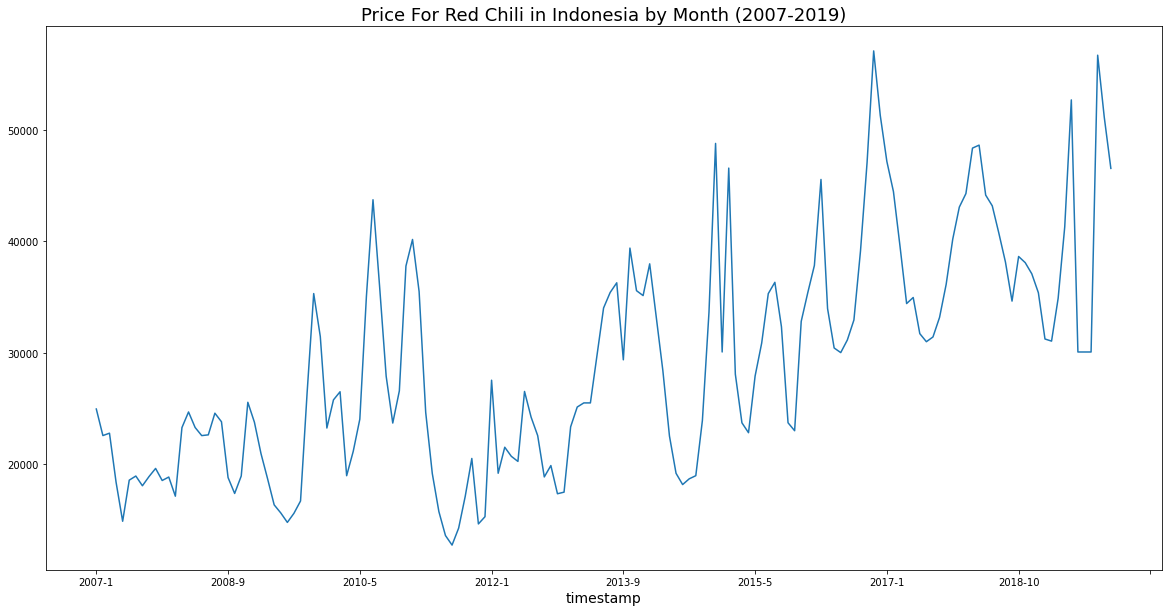

In [20]:
plt.figure(figsize=(20,10))
plt.title('Price For Red Chili in Indonesia by Month (2007-2019)', fontsize = 18)
plt.xlabel('Price', fontsize = 14)
plt.xlabel('Price', fontsize = 14)
chili_red_forc.plot(subplots=True)

In [0]:
train_split = int(len(chili_red_forc) * 0.8)

In [0]:
tf.random.set_seed(13)

In [0]:
chili_red_forc = chili_red_forc.values

In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [25]:
chili_red_forc.shape

(155,)

### Standardization for Chili (Red)

In [0]:
chili_red_forc_mean = chili_red_forc[:train_split].mean()
chili_red_forc_std = chili_red_forc[:train_split].std()

In [0]:
chili_red_forc = (chili_red_forc-chili_red_forc_mean)/chili_red_forc_std

In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])

  
  # print(f"start_index : {start_index} \nend_index={end_index}")
  return np.array(data), np.array(labels)

In [0]:
data_past = 20
predict_target = 0

x_train_uni, y_train_uni = univariate_data(
    dataset= chili_red_forc, 
    start_index= 0, 
    end_index= train_split, 
    history_size= data_past,
    target_size= predict_target)

x_val_uni, y_val_uni = univariate_data(
    dataset=chili_red_forc, 
    start_index=train_split, 
    end_index=None, 
    history_size=data_past,
    target_size=predict_target)

In [30]:
x_train_uni.shape, x_val_uni.shape

((104, 20, 1), (11, 20, 1))

In [0]:
def create_time_steps(length):
  return list(range(-length, 0))

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

### Recurrent Neural Network (RNN)
- LSTM (Long Short Term Memory)<br/><br/>

**Hyperparameters:**<br/>
- Batch size : 128
- Buffer size : 10000
- Epochs: 100
- LSTM unit size: 4
- Optimizer: Adam
- Loss: MAE

These are the final hyperparameters for this project. Tuning hyperparameters has been done quite a multiple times.

In [0]:
BATCH_SIZE = 128
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [0]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(4, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [49]:
simple_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [50]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(11, 1)


In [51]:
EVALUATION_INTERVAL = 100
EPOCHS = 100

lstm_model = simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/100
100/100 [==============================] - 1s 13ms/step - loss: 0.7227 - val_loss: 0.9940
Epoch 2/100
100/100 [==============================] - 1s 10ms/step - loss: 0.6370 - val_loss: 0.9491
Epoch 3/100
100/100 [==============================] - 1s 10ms/step - loss: 0.5830 - val_loss: 0.9318
Epoch 4/100
100/100 [==============================] - 1s 10ms/step - loss: 0.5354 - val_loss: 0.8946
Epoch 5/100
100/100 [==============================] - 1s 10ms/step - loss: 0.4943 - val_loss: 0.8702
Epoch 6/100
100/100 [==============================] - 1s 10ms/step - loss: 0.4743 - val_loss: 0.8359
Epoch 7/100
100/100 [==============================] - 1s 10ms/step - loss: 0.4575 - val_loss: 0.8260
Epoch 8/100
100/100 [==============================] - 1s 10ms/step - loss: 0.4419 - val_loss: 0.8223
Epoch 9/100
100/100 [==============================] - 1s 10ms/step - loss: 0.4293 - val_loss: 0.8080
Epoch 10/100
100/100 [==============================] - 1s 10ms/step - loss: 0.413

### Prediction Plot
This plot shows how the model developed tried to predict Chili Red price in 
Indonesia for one month ahead. It can be seen that the model is unable to predict very well.

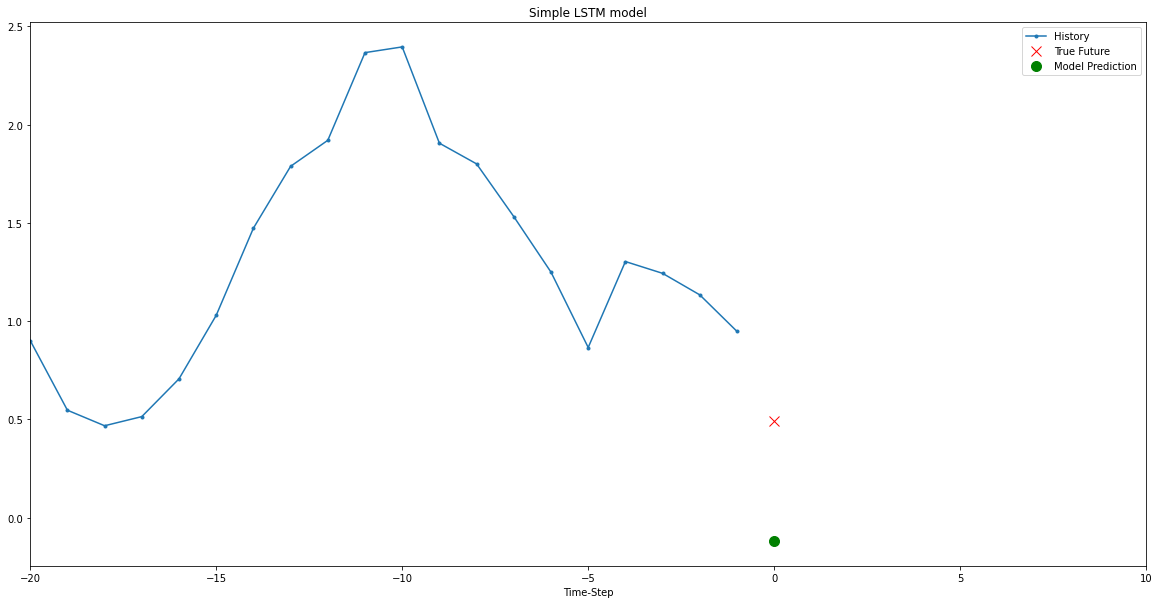

In [52]:
for x, y in val_univariate.take(1):
  plt.figure(figsize=(20,10))
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

### Overfitted Model

So, that's why the model can't predict very well!<br/>
Had been trying multiple "experiment" for hyperparameter, amount of layers, denses, yet still did not get the ideal model.

Graph below showed the performance of model in terms of training and validation loss. It can be clearly seen that the model is overfitted, since train loss is decreasing, yet validation loss is increasing.<br/>

Save it for now.<br/>
For the future, we can adjust the hyperparameters, choose the right LSTM unit and dense, et cetera in the name of trial and error.

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss =  history.history['val_loss']

  epochs = range(len(loss))

  plt.figure(figsize=(20,10))

  plt.plot(epochs, loss, 'b', label='Train loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

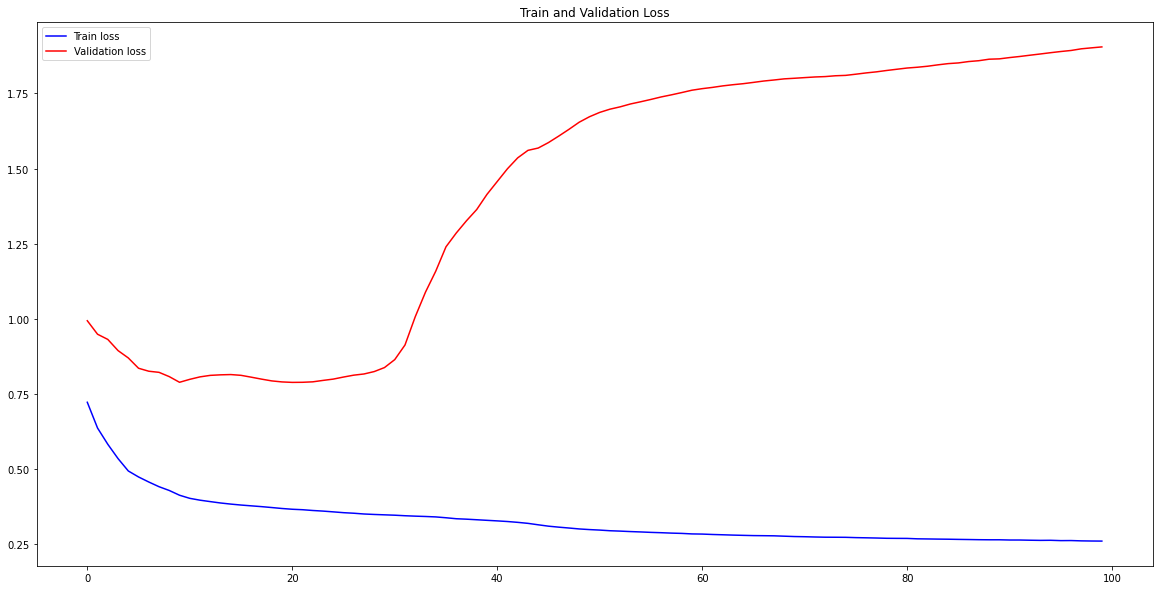

In [58]:
plot_train_history(lstm_model,
                   'Train and Validation Loss')